In [1]:
import pandas as pd
import os
from dotenv import load_dotenv
import requests
from bs4 import BeautifulSoup
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LinearSegmentedColormap, LogNorm
import geopandas as gpd
from shapely.ops import transform
from pyproj import Transformer
import cv2
from scipy.ndimage import gaussian_filter, maximum_filter, label
from jinja2 import Environment, FileSystemLoader

In [2]:
load_dotenv()
PROJECT_PATH = os.getenv("project_path")
PROJECT_PATH = os.path.normpath(PROJECT_PATH)
TEMP_DIR = os.path.join(PROJECT_PATH, "temp")
DATA_DIR = os.path.join(PROJECT_PATH, "data")
TEMPLATE_DIR = os.path.join(PROJECT_PATH, "html")

WWW_PATH  = os.getenv('www_path')
WWW_PATH = os.path.normpath(WWW_PATH)

os.environ["WRADLIB_DATA"] = TEMP_DIR

In [3]:
def get_files_sri():
    url = 'https://danepubliczne.imgw.pl/pl/datastore/getFilesList'

    headers = {
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.9',
        'Connection': 'keep-alive',
        'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
        'Origin': 'https://danepubliczne.imgw.pl',
        'Referer': 'https://danepubliczne.imgw.pl/pl/datastore?product=COMPO_SRI.comp.sri',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-GPC': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36',
        'X-Requested-With': 'XMLHttpRequest',
        'sec-ch-ua': '"Brave";v="137", "Chromium";v="137", "Not/A)Brand";v="24"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
    }

    cookies = {
        'ci_session': 'vstqm20aulpqntb3pmnb2925qq0t1k8e',  # replace with fresh session if needed
    }

    data = {
        'productType': 'oper',
        'path': '/Oper/Polrad/Produkty/POLCOMP/COMPO_SRI.comp.sri',
    }

    response = requests.post(url, headers=headers, cookies=cookies, data=data)

    # Parse the response using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract all hrefs from <a> tags
    all_links = [
        "https://danepubliczne.imgw.pl/" + a['href']
        for a in soup.find_all('a', href=True)
    ]

    return all_links

def download_file(url, dir_path):
    """
    Download a file from the given URL into the specified directory.

    Parameters:
    - url (str): The full URL of the file to download.
    - dir_path (str): Local directory to save the file into.
    """
    # Ensure directory exists
    os.makedirs(dir_path, exist_ok=True)

    # Extract the filename from the URL
    filename = url.split('/')[-1]

    # Full local path
    file_path = os.path.join(dir_path, filename)

    try:
        # Stream download for large files
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        print(f"Downloaded: {filename}")
        return file_path
    except requests.RequestException as e:
        print(f"Failed to download {url}: {e}")
        return None

def remove_all_files_from_dir(dir_path):
    """
    Remove all files from the specified directory.

    Parameters:
    - dir_path (str): Path to the directory to clear.
    """
    if not os.path.exists(dir_path):
        print(f"Directory does not exist: {dir_path}")
        return

    removed_files = 0
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        if os.path.isfile(file_path):
            try:
                os.remove(file_path)
                removed_files += 1
            except Exception as e:
                print(f"Failed to remove {file_path}: {e}")

    print(f"Removed {removed_files} files from {dir_path}")


# Find local maximas with minimum distance and integrated Gaussian smoothing
def find_local_maximas(arr, min_distance=2, sigma=1):
    # Apply Gaussian smoothing
    smoothed_arr = gaussian_filter(arr, sigma=sigma)
    
    # Find local maxima using maximum filter
    max_filt = maximum_filter(smoothed_arr, size=2*min_distance+1)
    maximas = (smoothed_arr == max_filt)
    
    # Remove maximas that are too close using labeling
    structure = np.ones((3, 3))  # 8-connectivity
    labeled, num_features = label(maximas, structure=structure)
    for i in range(1, num_features + 1):
        coords = np.where(labeled == i)
        if len(coords[0]) > 1:  # If multiple points in one connected component
            # Keep only the point with highest value
            values = smoothed_arr[coords]
            max_idx = np.argmax(values)
            keep = (coords[0][max_idx], coords[1][max_idx])
            maximas[coords] = False
            maximas[keep] = True
            
    return maximas

In [4]:
urls = get_files_sri()
urls = [f for f in urls if f.endswith('sri')]

In [5]:
rbdict_list = []

for url in urls[-3:]:
    file_path = download_file(url,TEMP_DIR)
    filename = wrl.util.get_wradlib_data_file(file_path)
    rbdict   = wrl.io.read_rainbow(filename)
    rbdict_list.append(rbdict)

Downloaded: 2025061912300000dBR.sri
Downloaded: 2025061912350000dBR.sri
Downloaded: 2025061912400000dBR.sri


In [6]:
arr1 = np.array(rbdict_list[-1]['product']['data']['radarpicture']['datamap']['data'])
arr2 = np.array(rbdict_list[-2]['product']['data']['radarpicture']['datamap']['data'])

flow = cv2.calcOpticalFlowFarneback(arr1, arr2, None, 
                                    pyr_scale=0.5, levels=3, winsize=15, 
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

In [7]:
u = flow[...,0]
v = flow[...,1]
speed = (u**2+v*100)**0.5
h, w = flow.shape[:2]

C:\Users\mateu\AppData\Local\Temp\ipykernel_26372\955937763.py:3: RuntimeWarning: invalid value encountered in sqrt
  speed = (u**2+v*100)**0.5


In [8]:
rbdict = rbdict_list[-1]

min_val = float(rbdict['product']['data']['radarpicture']['@min'])
max_val = float(rbdict['product']['data']['radarpicture']['@max'])
depth = int(rbdict['product']['data']['radarpicture']['datamap']['@depth'])
proj4string = rbdict['product']['data']['radarpicture']['projection']['proj4string']

lat_lr = float(rbdict['product']['data']['radarpicture']['projection']['@lat_lr'])
lat_ul = float(rbdict['product']['data']['radarpicture']['projection']['@lat_ul'])
lon_lr = float(rbdict['product']['data']['radarpicture']['projection']['@lon_lr'])
lon_ul =  float(rbdict['product']['data']['radarpicture']['projection']['@lon_ul'])

raw_values = np.array(rbdict['product']['data']['radarpicture']['datamap']['data'])

# correct scaling
scale = np.power(2, depth) - 1
values_db = (raw_values / scale) * (max_val - min_val) + min_val
values = 10 ** (values_db / 10)

datetime_str = rbdict['product']['data']['@date']+' '+rbdict['product']['data']['@time']


In [9]:
df_cities = pd.read_csv(os.path.join(DATA_DIR, "cities.txt"),sep='\t')

Original CRS: EPSG:4326
Removed 3 files from D:\SkyCloud\skycloud\temp


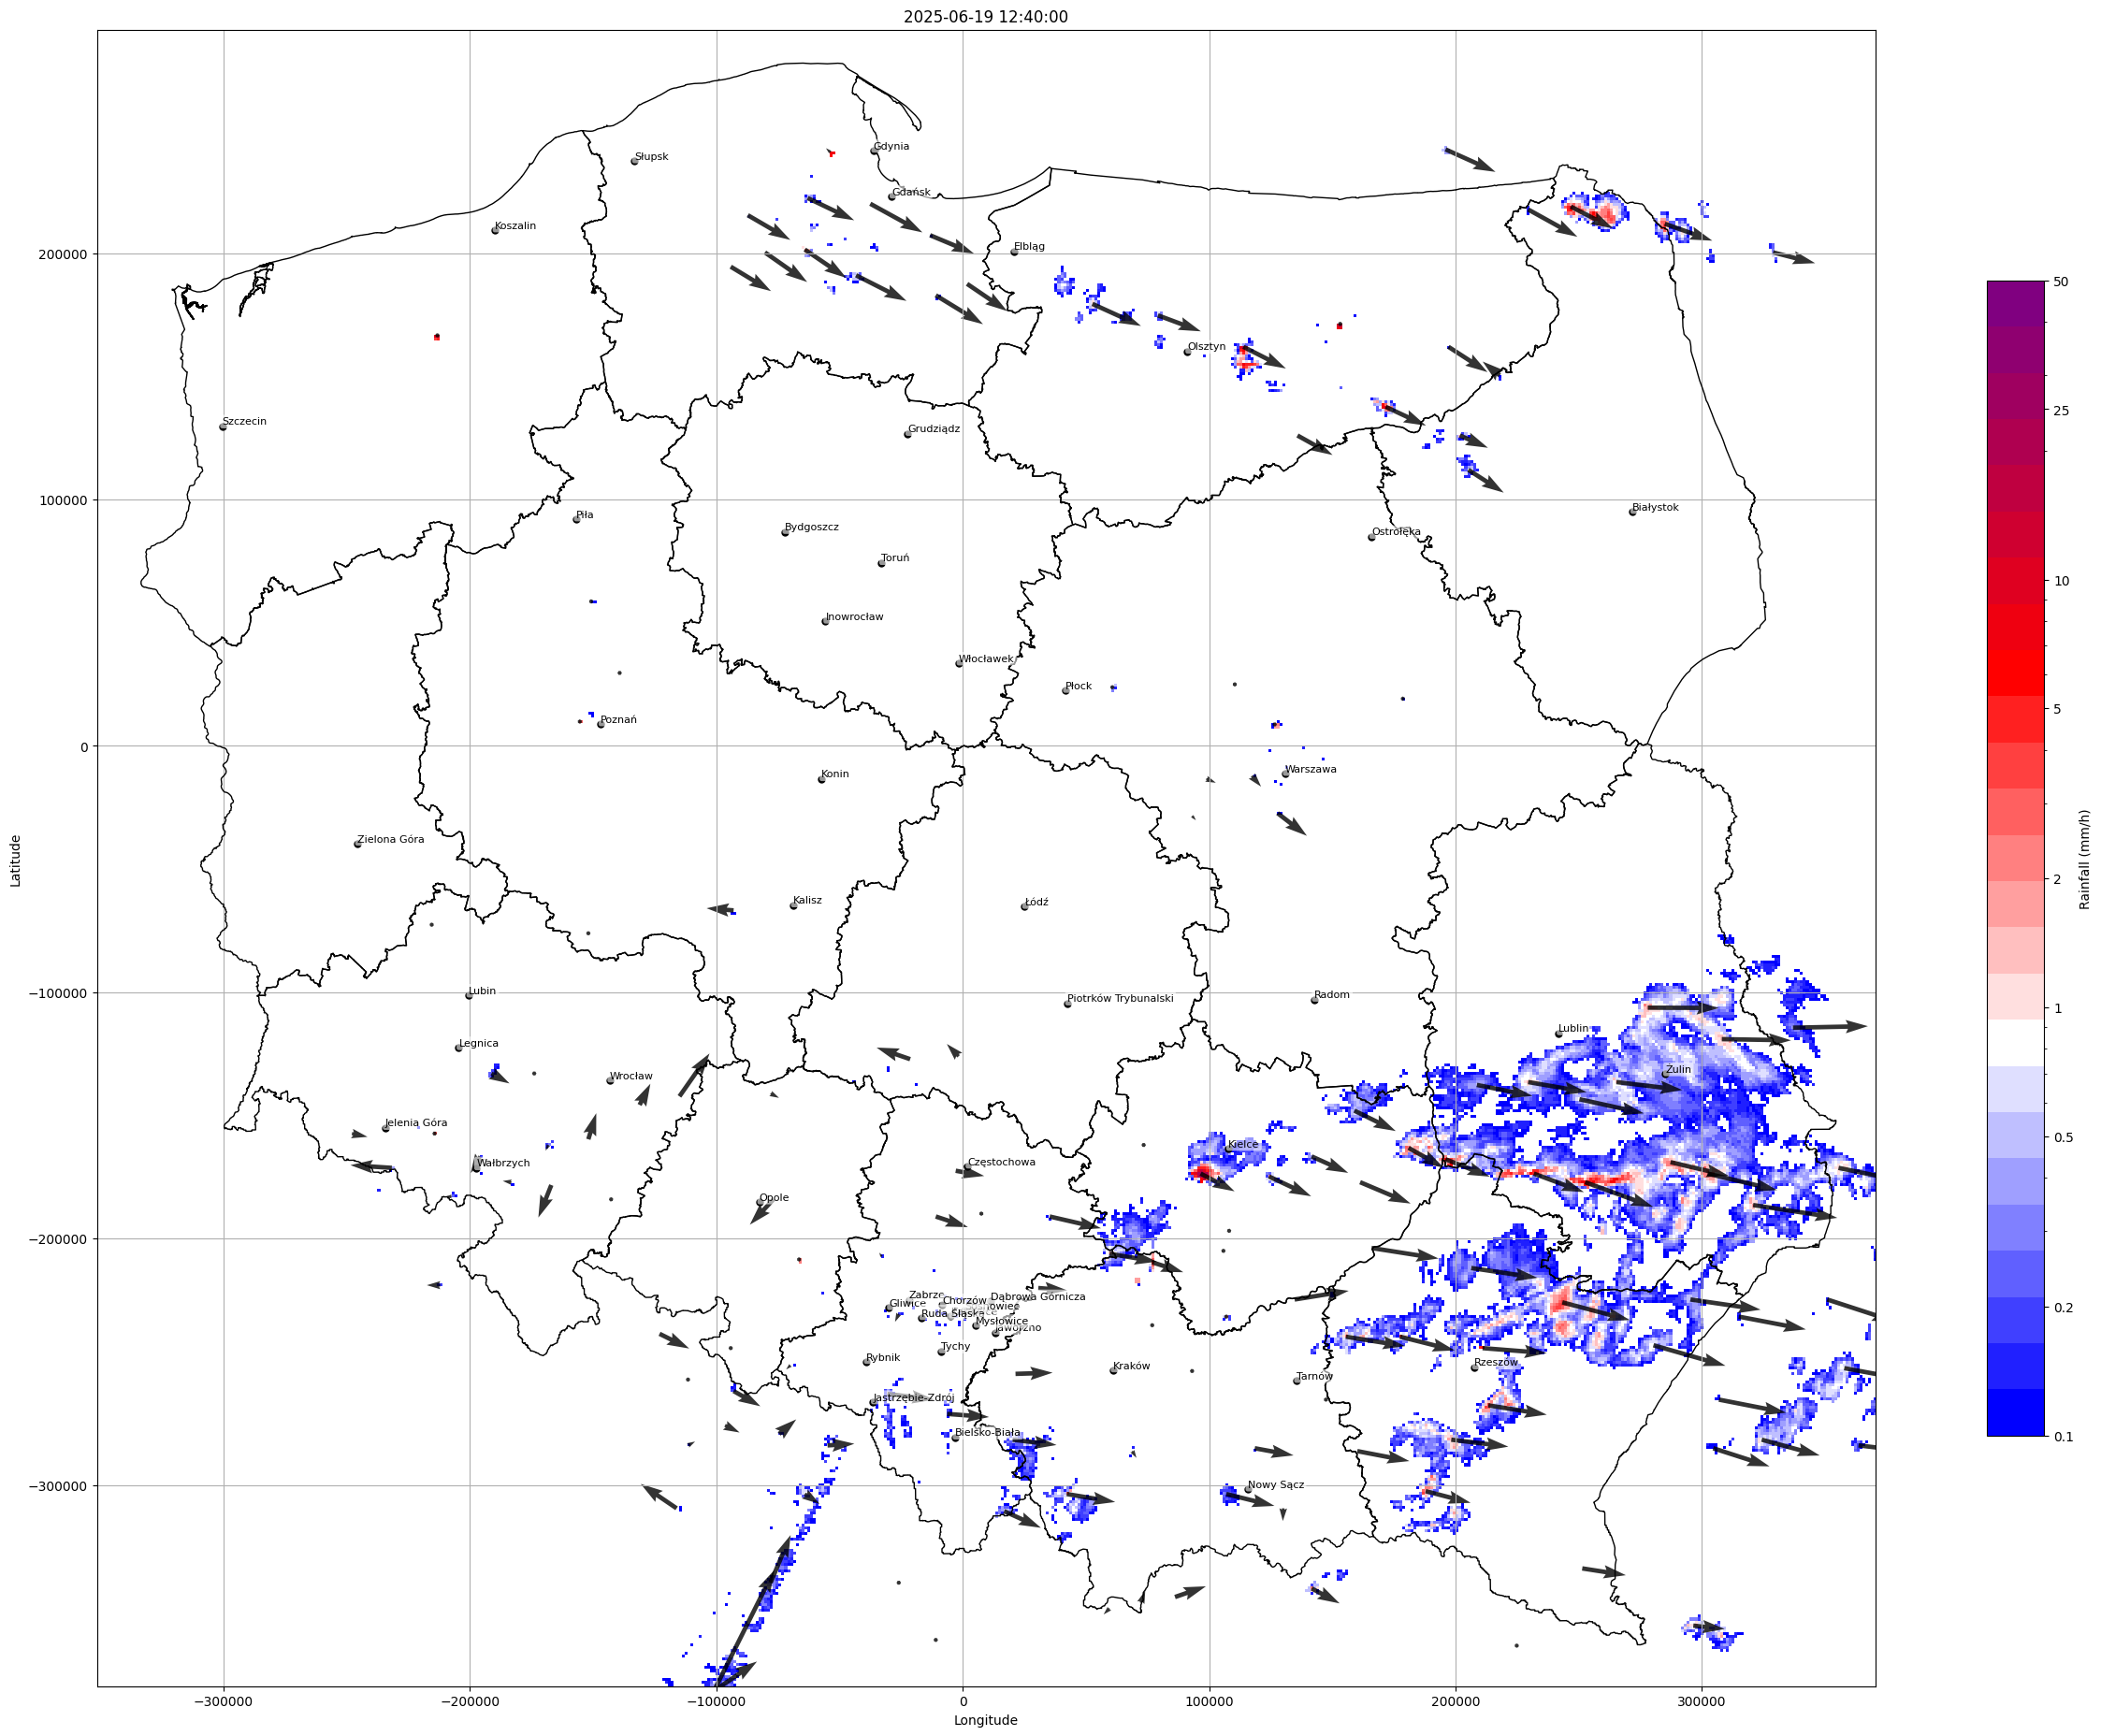

In [10]:
min_rain_threshold = 0.1

fig, ax = plt.subplots(figsize=(25, 25))


shp_path = os.path.join(DATA_DIR, "gadm41_POL_1.shp")
gdf = gpd.read_file(shp_path)

print("Original CRS:", gdf.crs)  # Optional: verify the original CRS



#TRANSFORM SHP

# Define the source and target CRS
source_crs = gdf.crs  # e.g., EPSG:4326
transformer = Transformer.from_crs(source_crs, proj4string, always_xy=True)

# Function to transform geometries using the transformer
def transform_geometry(geom):
    return transform(transformer.transform, geom)
gdf['geometry'] = gdf['geometry'].apply(transform_geometry)




# Plot the GeoDataFrame on the axes
gdf.boundary.plot(ax=ax, color='black', linewidth=1)

x_lr, y_lr = transformer.transform(lon_lr, lat_lr)  # Lower-right
x_ul, y_ul = transformer.transform(lon_ul, lat_ul)  # Upper-left

# Define extent for plt.imshow: [minx, maxx, miny, maxy] in projected coordinates (meters)
extent = [min(x_ul, x_lr), max(x_ul, x_lr), min(y_lr, y_ul), max(y_lr, y_ul)]

# Create Transformer
transformer = Transformer.from_crs("EPSG:4326", proj4string, always_xy=True)

values_plot = values.copy()
values_plot[values_plot < min_rain_threshold] = np.nan  # clip values below 0.1

# --- Custom colormap: blue -> white -> red -> purple ---
colors = [
    (0, 0, 1),    # Blue
    (1, 1, 1),    # White
    (1, 0, 0),    # Red
    (0.5, 0, 0.5) # Purple
]
custom_cmap = LinearSegmentedColormap.from_list('custom_radar', colors, N=25)


im = plt.imshow(
    values_plot,
    cmap=custom_cmap,  # Your custom colormap
    origin='upper',
    norm=LogNorm(vmin=0.1, vmax=50),
    interpolation='nearest',
    extent=extent,  # Use transformed coordinates
    aspect='equal'  # Ensure equal scaling
)

step = 1
# Subsample grid for arrows

x, y = np.meshgrid(np.linspace(x_ul, x_lr, w),np.linspace(y_ul,y_lr, h))

#u = np.fliplr(u)  # Or use np.flipud(u) or u = -u depending on needs

values_maximas = find_local_maximas(values, min_distance=10, sigma=1)

valid_indices = np.where(values_maximas)

# Extract only valid points for plotting
x_sub = x[valid_indices]
y_sub = y[valid_indices]
u_sub = u[valid_indices]
v_sub = v[valid_indices]

ax.quiver(x_sub, y_sub, -u_sub, v_sub, color='k',scale=150,alpha=0.8,width=0.0025)  # Flip v for correct orientation

ax.set_aspect('equal')

ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 25, 50]
cbar = plt.colorbar(im, ticks=ticks, shrink=0.5)
cbar.ax.set_yticklabels([str(t) for t in ticks])
cbar.set_label('Rainfall (mm/h)')

ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_title(datetime_str)


df_cities["x"], df_cities["y"] = transformer.transform(
    df_cities["longitude"].values,  # always X (lon) first
    df_cities["latitude"].values    # then Y (lat)
)

for _, city in df_cities.iterrows():
    ax.plot(city["x"], city["y"], "o", color="k", markersize=5)  # Dot
    ax.text(
    city["x"], city["y"], city["city"],
    fontsize=8,
    ha="left", va="bottom",
    bbox=dict(
        facecolor="white",   # background color
        alpha=0.6,           # transparency (0 = fully transparent, 1 = opaque)
        edgecolor="none",    # no border
        boxstyle="round,pad=0.2"  # rounded box with padding
    )
)


# Adjust layout and display
plt.tight_layout()

pl_x_lr, pl_y_lr = transformer.transform(24.15, 48.80)  # Lower-right
pl_x_ul, pl_y_ul = transformer.transform(13.6, 54.84)  # Upper-left

ax.set_xlim([min(pl_x_lr,pl_x_ul),max(pl_x_lr,pl_x_ul)])
ax.set_ylim([min(pl_y_lr,pl_y_ul),max(pl_y_lr,pl_y_ul)])
#plt.show()

output_file = os.path.join(WWW_PATH,"radarimage.png")
plt.savefig(output_file)

remove_all_files_from_dir(TEMP_DIR)

In [ ]:

min_rain_threshold = 0.1

# Set up figure with no padding
fig, ax = plt.subplots(figsize=(10, 10), facecolor='none')  # Transparent figure background
ax.set_facecolor('none')  # Transparent axes background

# Remove all axes elements
ax.set_axis_off()  # Hide axes, labels, ticks, and frame


# Define extent in geographic coordinates (degrees): [minx, maxx, miny, maxy]
extent = [min(lon_ul, lon_lr), max(lon_ul, lon_lr), min(lat_lr, lat_ul), max(lat_lr, lat_ul)]

# Prepare radar data
values_plot = values.copy()
values_plot[values_plot < min_rain_threshold] = np.nan  # Set values below threshold to NaN

# Custom colormap: blue -> white -> red -> purple
colors = [
    (0, 0, 1),    # Blue
    (1, 1, 1),    # White
    (1, 0, 0),    # Red
    (0.5, 0, 0.5) # Purple
]
custom_cmap = LinearSegmentedColormap.from_list('custom_radar', colors, N=25)

# Make colormap transparent for NaN values
custom_cmap.set_bad(alpha=0)  # Transparent for NaN (non-data areas)

# Plot radar data
im = ax.imshow(
    values_plot,
    cmap=custom_cmap,
    origin='upper',
    norm=LogNorm(vmin=0.1, vmax=50),
    interpolation='nearest',
    extent=extent,  # Use geographic coordinates (lon/lat)
    zorder=10
)

# Create grid for quiver plot (in lon/lat)
x, y = np.meshgrid(np.linspace(lon_ul, lon_lr, w), np.linspace(lat_ul, lat_lr, h))

# Find local maxima for quiver plot
values_maximas = find_local_maximas(values, min_distance=10, sigma=1)
valid_indices = np.where(values_maximas)

# Extract valid points for quiver
x_sub = x[valid_indices]
y_sub = y[valid_indices]
u_sub = u[valid_indices]
v_sub = v[valid_indices]

# Plot wind vectors
ax.quiver(x_sub, y_sub, -u_sub, v_sub, color='k', scale=150, alpha=0.8, width=0.0025, zorder=20)

# Plot cities (assuming df_cities has 'longitude', 'latitude', 'city' columns)

# Set plot limits to match extent (no padding)
ax.set_xlim([min(lon_lr, lon_ul), max(lon_lr, lon_ul)])
ax.set_ylim([min(lat_lr, lat_ul), max(lat_lr, lat_ul)])

# Remove padding and margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save as PNG with transparent background and no padding
output_file = os.path.join(WWW_PATH, "radarimage_www.png")
plt.savefig(output_file, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

# Close plot to free memory
plt.close(fig)

In [21]:
env = Environment(loader=FileSystemLoader(TEMPLATE_DIR))
template = env.get_template('template_map.php')

In [ ]:
# Render the template
html = template.render(
    title="IMGW",
    lon_min=min(lon_lr, lon_ul),
    lon_max=max(lon_lr, lon_ul),
    lat_min=min(lat_lr, lat_ul),
    lat_max=max(lat_lr, lat_ul),
    center_lon=(min(lon_lr, lon_ul)+max(lon_lr, lon_ul))/2,
    center_lat=(min(lat_lr, lat_ul)+max(lat_lr, lat_ul))/2,
    API_KEY = os.getenv('google_maps_api_key'),
    DATETIME = datetime_str
)

# Save output
output_file = os.path.join(WWW_PATH,"index.html")
with open(output_file, "w", encoding="utf-8") as f:
    f.write(html)

print(f"HTML written to {output_file}")

HTML written to D:\SkyCloud\www\index.html
